In [56]:
import pandas as pd
import cv2
from pathlib2 import Path
from sewar.full_ref import vifp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List
from scipy.interpolate import UnivariateSpline
import sys
import os
import scipy.integrate as integrate
sys.path.insert(0, os.path.abspath(".."))

from reliabilitycli.src.utils.metric import performance_area
from reliabilitycli.src.constants.imagenet_16_class_map import imagenet_16_class_wnid_to_category
from reliabilitycli.src.workspace import Workspace
from reliabilitycli.commands.eval import get_eval_stats
from reliabilitycli.datasets.imagenet import ImagenetDatasetInfo
from reliabilitycli.commands.analyze import analyze, analyze_models, analyze_model_eval_df, AnalysisResult

In [19]:
eval_df = pd.read_csv("/home/user/Documents/Research/reliabilitycli/workspaces/gaussian_blur_imagenet16/eval_results.csv", index_col=0)
gaussian_blur_human_df = pd.read_csv('../workspaces/gaussian_blur_imagenet16/human_results.csv')
glass_blur_human_df = pd.read_csv('../workspaces/glass_blur_imagenet16/human_results.csv')

# human_df = pd.read_csv("/home/user/Documents/Research/reliabilitycli/snippets/human_results.csv")
# human_df['transformation'].unique()
# gaussian_blur_human_df = human_df[human_df['transformation'] == 'gaussian_blur']
# glass_blur_human_df = human_df[human_df['transformation'] == 'glass_blur']
# gaussian_blur_human_df.to_csv('../workspaces/gaussian_blur_imagenet16/human_results.csv')
# glass_blur_human_df.to_csv('../workspaces/glass_blur_imagenet16/human_results.csv')

In [20]:
models_analysis_results = analyze_models(20, 0.05, eval_df)
human_analysis_results = analyze_model_eval_df(gaussian_blur_human_df, 20, 0.05)

In [66]:
def spl_to_accs_monotonic(xs: np.array, spl: UnivariateSpline):
    ys = np.clip(spl(xs), 0, 1)
    for i in range(1, len(ys)):
        if ys[i] > ys[i - 1]:
            ys[i] = ys[i - 1]
    return ys

<AxesSubplot: >

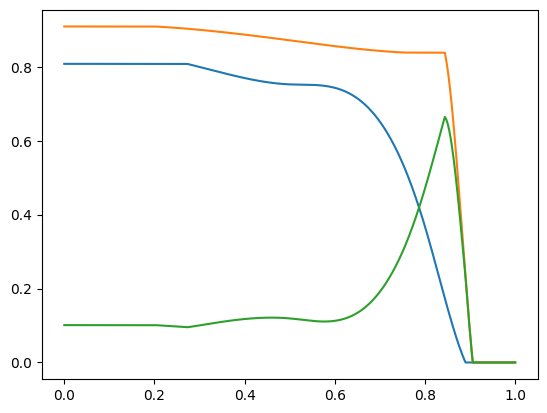

In [76]:
xs = np.arange(10000) / 10000
# ai_ys = models_analysis_results['Erichson2022NoisyMix'].transf_spl(xs)
ai_ys = spl_to_accs_monotonic(xs, models_analysis_results['Erichson2022NoisyMix'].transf_spl)
# human_ys = human_analysis_results.transf_spl(xs)
human_ys = spl_to_accs_monotonic(xs, human_analysis_results.transf_spl)

sns.lineplot(x=xs, y=ai_ys)
sns.lineplot(x=xs, y=human_ys)
diff = np.where(human_ys > ai_ys, human_ys - ai_ys, 0)
sns.lineplot(x=xs, y=diff)

In [87]:
def compare_two_splines(spl1: UnivariateSpline, spl2: UnivariateSpline):
    """
    Given 2 spline models (e.g. ai and human), return the area difference
    if spl1 is ai spline and spl2 is human spl, then returned value is (ai minus human area, human minus ai human area)
    """
    xs = np.arange(10000) / 10000
    spl1_ys = spl_to_accs_monotonic(xs, spl1)
    spl2_ys = spl_to_accs_monotonic(xs, spl2)
    spl_2_1_diff = np.where(spl2_ys > spl1_ys, spl2_ys - spl1_ys, 0)
    spl_1_2_diff = np.where(spl1_ys > spl2_ys, spl1_ys - spl2_ys, 0)
    spl_2_1_area = np.trapz(spl_2_1_diff, x=xs)
    spl_1_2_area = np.trapz(spl_1_2_diff, x=xs)

    area1 = np.trapz(spl1_ys, x=xs)
    area2 = np.trapz(spl2_ys, x=xs)

    p_1_2 = 1 - (spl_1_2_area / area1)
    p_2_1 = 1 - (spl_2_1_area / area2)
    return area1, area2, spl_1_2_area, spl_2_1_area, p_1_2, p_2_1


compare_two_splines(models_analysis_results['Erichson2022NoisyMix'].transf_spl, human_analysis_results.transf_spl)

(0.6110584125080137,
 0.7697711069403006,
 0.0,
 0.15871269443228692,
 1.0,
 0.7938183272906398)

In [11]:
models_analysis_results['Erichson2022NoisyMix']

AnalysisResult(n_bins=20, smoothing_factor=0.05, raw_orig_accs=[0.8227599738391105, 0.8165784832451499, 0.8253851797505503, 0.8198451794510908, 0.8333333333333334, 0.8323991031390134, 0.815211842776927, 0.8327727054300816, 0.8314657104437472, 0.8229508196721311, 0.8171230720805792, 0.8337236533957846, 0.8240700218818381, 0.8147624933780682, 0.8303964757709251, 0.8017204301075269, 0.8142011834319527, 0.0, 0, 0], raw_transf_accs=[0.8238500109003706, 0.8165784832451499, 0.8239178283198826, 0.8191414496833216, 0.8333333333333334, 0.8211883408071748, 0.7896886166411434, 0.7981739548294089, 0.7884356790676826, 0.7719489981785064, 0.7576329870947435, 0.7403070517824616, 0.7172866520787746, 0.6659014656542469, 0.6384518565135305, 0.5713978494623656, 0.514792899408284, 0.0, 0, 0], raw_pred_sims=[0.9973839110529757, 0.9735449735449735, 0.9567131327953045, 0.9437016185784659, 0.9408805031446541, 0.9108744394618834, 0.9040326697294538, 0.8947621335896204, 0.8812191842223218, 0.8426229508196721, 0.

In [2]:
# eval_results_path = ""
# df = pd.read_csv("../snippets/human_results.csv")
# df = pd.read_csv("../workspaces/glass_blur_imagenet16/eval_results.csv", index_col=0)
n_bins = 25
smoothing_factor = n_bins
df = pd.read_csv("../snippets/eval_results.csv", index_col=0)
df

,orig_pred,transf_pred,label,image_path,transformation,transformation_parameter,vd_score,model
0,140,82,140,/home/user/datasets/ImageNet/val/n02027492/I...,gaussian_blur,719,0.852039,<class 'torchvision.models.resnet.ResNet'>
1,281,285,282,/home/user/datasets/ImageNet/val/n02123159/I...,gaussian_blur,715,0.899038,<class 'torchvision.models.resnet.ResNet'>
2,203,203,185,/home/user/datasets/ImageNet/val/n02094114/I...,gaussian_blur,108,0.227586,<class 'torchvision.models.resnet.ResNet'>
3,194,194,194,/home/user/datasets/ImageNet/val/n02096437/I...,gaussian_blur,974,0.846717,<class 'torchvision.models.resnet.ResNet'>
4,136,136,136,/home/user/datasets/ImageNet/val/n02017213/I...,gaussian_blur,466,0.754259,<class 'torchvision.models.resnet.ResNet'>
...,...,...,...,...,...,...,...,...
399995,297,297,297,/home/user/datasets/ImageNet/val/n02134418/I...,gaussian_blur,667,0.761162,<class 'torch.nn.modules.container.Sequential'>
399996,20,360,20,/home/user/datasets/ImageNet/val/n01601694/I...,gaussian_blur,872,0.881453,<class 'torch.nn.modules.container.Sequential'>
399997,165,165,165,/home/user/datasets/ImageNet/val/n02089078/I...,gaussian_blur,233,0.567665,<class 'torch.nn.modules.container.Sequential'>
399998,249,249,249,/home/user/datasets/ImageNet/val/n02110063/I...,gaussian_blur,216,0.715997,<class 'torch.nn.modules.container.Sequential'>


In [16]:
list(df['model'].unique())

["<class 'torchvision.models.resnet.ResNet'>",
 "<class 'torch.nn.modules.container.Sequential'>"]

In [3]:
model_name = "<class 'torchvision.models.resnet.ResNet'>"
model_df = df[df['model'] == model_name]

In [4]:
def calculate_acc(df: pd.DataFrame, col1: str, col2: str) -> float:
    return (df[col1] == df[col2]).sum() / len(df)

In [5]:
# first turn into vd_score bins
bins_dfs = []
for i in range(n_bins):
	bins_dfs.append(df[(df['vd_score'] > i / n_bins) & (df['vd_score'] < ((i + 1) / n_bins))])

In [6]:
def calculate_accs(bins_dfs: List[pd.DataFrame], col1: str, col2: str):
    prev_acc = 0
    accs = []
    for bin_df in bins_dfs:
        if len(bin_df) == 0:
            # if current vd bin has no data, reuse previous accuracy to avoid division by 0
            acc = prev_acc
        else:
            acc = calculate_acc(bin_df, col1, col2)
        accs.append(acc)
    return accs

In [7]:
# for each vd_score bin, calculate accuracy
orig_accs = calculate_accs(bins_dfs, 'orig_pred', 'label')
transf_accs = calculate_accs(bins_dfs, 'transf_pred', 'label')
pred_sims = calculate_accs(bins_dfs, 'transf_pred', 'orig_pred')

<AxesSubplot: >

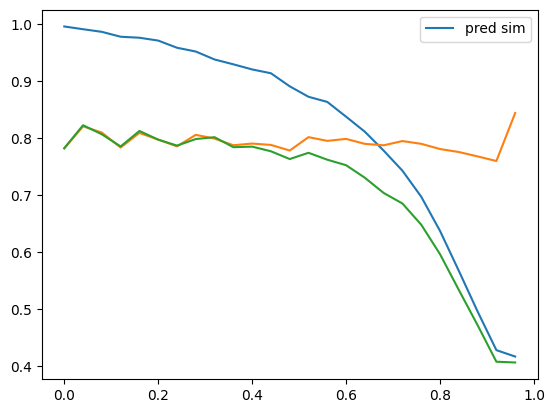

In [8]:
xs = np.arange(n_bins) / n_bins
sns.lineplot(x=xs, y=pred_sims, label="pred sim")
sns.lineplot(x=xs, y=orig_accs)
sns.lineplot(x=xs, y=transf_accs)

In [9]:
# produce splines
orig_spl = UnivariateSpline(xs, orig_accs, s=smoothing_factor)
transf_spl = UnivariateSpline(xs, transf_accs, s=smoothing_factor)
pred_sim_spl = UnivariateSpline(xs, pred_sims, s=smoothing_factor)

In [10]:
# recalculate smoothed accuracies
orig_accs = orig_spl(xs)
transf_accs = transf_spl(xs)
pred_sims = pred_sim_spl(xs)

<AxesSubplot: >

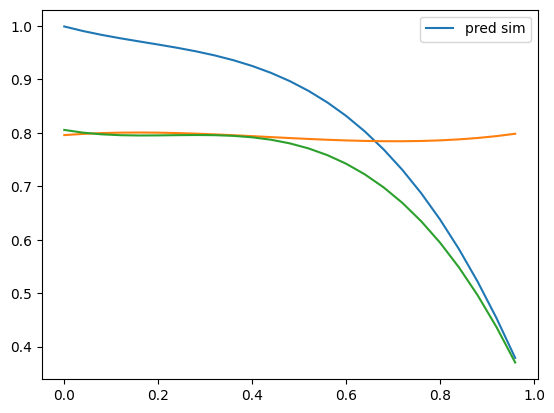

In [11]:
sns.lineplot(x=xs, y=pred_sims, label="pred sim")
sns.lineplot(x=xs, y=orig_accs)
sns.lineplot(x=xs, y=transf_accs)

In [13]:
# calculate performance area under curve
orig_acc_area = performance_area(orig_accs)
transf_acc_area = performance_area(transf_accs)
pred_sim_area = performance_area(pred_sims)

In [48]:
from scipy import integrate

def f(x):
    return 0.5

def g(x):
    return np.sin(x)

def integrand(x):
    return g(x) - f(x)
    # return f(x) - g(x)

def integrand2(x):
    return f(x) - g(x)

lower_bound = 0
upper_bound = 1

result, error = integrate.quad(integrand, 0, 10)
result, error = integrate.quad(integrand2, 0, 10)

print(result)  # Output: 0.16666666666666666


3.1609284709235483


<AxesSubplot: >

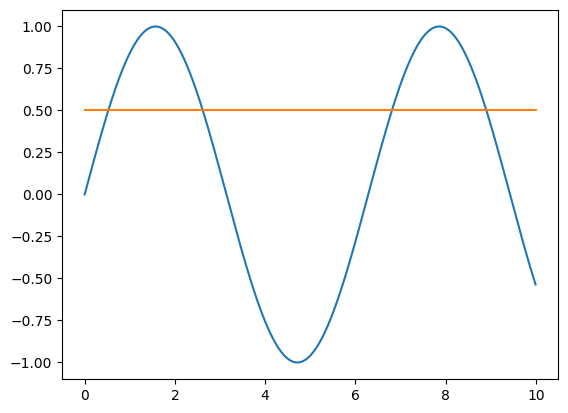

In [44]:
xs = np.arange(1000) / 100
f_y = np.array([f(x) for x in xs])
g_y = np.array([g(x) for x in xs])
sns.lineplot(x=xs, y=g_y)
sns.lineplot(x=xs, y=f_y)

In [45]:
integrate.quad(integrand, 0, 10)

(3.1609284709235483, 9.921213266500977e-12)

In [54]:
human_analysis_results.orig_spl(0.5)

array(0.98129349)

In [55]:
f_y @ g_y

92.08881545046405